# Prepare environment

In [ ]:
!pip install datasets langchain[llms] tiktoken huggingface_hub

In [ ]:
import datasets
import huggingface_hub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.output_parsers import PydanticOutputParser, StructuredOutputParser, OutputFixingParser, ResponseSchema
from langchain.callbacks import get_openai_callback
import json
from datetime import datetime
import time
import pickle
from google.colab import files
from pydantic import BaseModel, Field, validator
from typing import List

In [ ]:
# Configure general variables
seed = 42
openai_org = "..."
openai_key = "..."

# Prepare datasets

In [ ]:
# Load the original training dataset
train = datasets.load_dataset("tum-nlp/IDMGSP", "train+gpt3", split="train")

# Randomly shuffle the dataset
train_shuffled = train.shuffle(seed=seed)

# Create one training dataset with real papers
train_real = train_shuffled.filter(lambda x: x["src"] == "real")

# Create one training dataset with fake papers that includes alternating examples from each source
train_scigen = train_shuffled.filter(lambda x: x["src"] == "scigen")
train_galactica = train_shuffled.filter(lambda x: x["src"] == "galactica")
train_gpt2 = train_shuffled.filter(lambda x: x["src"] == "gpt2")
train_gpt3 = train_shuffled.filter(lambda x: x["src"] == "gpt3")
train_chatgpt = train_shuffled.filter(lambda x: x["src"] == "chatgpt")
train_fake = datasets.interleave_datasets([train_scigen, train_galactica, train_gpt2, train_gpt3, train_chatgpt])

Generating train split:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17200 [00:00<?, ? examples/s]

In [ ]:
# Load the original test datasets
test = datasets.load_dataset("tum-nlp/IDMGSP", "classifier_input", split="test")
ood_gpt3 = datasets.load_dataset("tum-nlp/IDMGSP", "ood_gpt3", split="test")
ood_real = datasets.load_dataset("tum-nlp/IDMGSP", "ood_real", split="test")
test_cc = datasets.load_dataset("tum-nlp/IDMGSP", "test-cc", split="test")
tecg = datasets.load_dataset("tum-nlp/IDMGSP", "tecg", split="test", verification_mode="no_checks")

# Randomly shuffle the datasets
test_shuffled = test.shuffle(seed=seed)
ood_gpt3_shuffled = ood_gpt3.shuffle(seed=seed)
ood_real_shuffled = ood_real.shuffle(seed=seed)
test_cc_shuffled = test_cc.shuffle(seed=seed)
tecg_shuffled = tecg.shuffle(seed=seed)

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4000 [00:00<?, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Define prompting functions

In [ ]:
# Define reusable prompt parts
general_task = "You are a data scientist. Your task is to engineer and score a set of features suitable to distinguish scientific papers written by humans from scientific papers written by machine language models."
intro_human = "###### The following paper was written by a HUMAN ######"
intro_machine = "###### The following paper was written by a MACHINE ######"
instructions_generation = """###### Instructions ######\n\n\
Based on the above examples, describe a list of features that would best distinguish human- and machine-written scientific papers from each other. \
Features can be everything from very low level (e.g., occurrences of a specific word) to very high level (e.g., logical conclusiveness of argumentation). \
Each feature should be measured on a scale of 0 to 10. Therefore, indicate for each feature what 0 and 10 mean, respectively (e.g., 0 = "few", 10 = "many"). \
The features should generalize to scientific papers in a broad range of scientific fields."""
instructions_merge_pre = "Here is a list of features with potential duplicates. Each features has the properties 'name', 'zero', 'ten', and 'hypothesis'."
instructions_merge_post = "Consolidate the list of features by merging features that are very similar to each other (i.e., features that measure something similar even though their name may be different)."
instructions_score = "###### Instructions ######\n\nEvaluate the above scientific paper along the following list of criteria. For each criteria, assign an integer value from 0 to 10 that most accurately describes the scientific paper."


# Define the prompt template for system messages
system_message_template = SystemMessagePromptTemplate(prompt=PromptTemplate(
    template="{general_task}",
    input_variables=[],
    partial_variables={
        "general_task": general_task
    }
))

# Define the prompt template for with the instructions to generate features
generation_template = HumanMessagePromptTemplate(prompt=PromptTemplate(
    template="{label_a}\n\nAbstract:\n{abstr_a}\n\nIntroduction:\n{intro_a}\n\nConclusion:\n{concl_a}\n\n{label_b}\n\nAbstract:\n{abstr_b}\n\nIntroduction:\n{intro_b}\n\nConclusion:\n{concl_b}\n\n{instructions}\n\n{format_instructions}",
    input_variables=["label_a", "abstr_a", "intro_a", "concl_a", "label_b", "abstr_b", "intro_b", "concl_b", "format_instructions"],
    partial_variables={
        "instructions": instructions_generation
    }
))

# Define the prompt template with the instructions to consolidate features
merge_template = HumanMessagePromptTemplate(prompt=PromptTemplate(
    template="{instructions_merge_pre}\n\n{features}\n\n{instructions_merge_post}\n\n{format_instructions}",
    input_variables=["features", "format_instructions"],
    partial_variables={
        "instructions_merge_pre": instructions_merge_pre,
        "instructions_merge_post": instructions_merge_post
    }
))

# Define the prompt template with the instructions to score a paper along a set of features
score_template = HumanMessagePromptTemplate(prompt=PromptTemplate(
    template="Here is a scientific paper that you should evaluate.\n\nAbstract:\n{abstr}\n\nIntroduction:\n{intro}\n\nConclusion:\n{concl}\n\n{instructions_score} {format_instructions}",
    input_variables=["abstr", "intro", "concl", "format_instructions"],
    partial_variables={
        "instructions_score": instructions_score
    }
))


# Define classes for output parsing
class Feature(BaseModel):
    name: str = Field(description="concise name of the feature")
    zero: str = Field(description="meaning of feature value of 0")
    ten: str = Field(description="meaning of feature value of 10")
    hypothesis: str = Field(description="hypothesis of how human- and machine-written papers would score differently on this feature")

class FeatureSet(BaseModel):
    features: List[Feature] = Field(description="list of features")


def generate_features(model, abstr_a, intro_a, concl_a, is_human_a, abstr_b, intro_b, concl_b, is_human_b):
    # Assert that one paper is human- and one is machine-generated
    assert is_human_a is not is_human_b

    # Define the output schema and parser (OutputFixingParser will try to fix the LLM output in case the PydanticOutputParser fails)
    output_parser = OutputFixingParser.from_llm(
        parser=PydanticOutputParser(pydantic_object=FeatureSet),
        llm=model
    )

    # Assemble a list of chat messages
    messages = []
    messages.append(system_message_template.format())
    messages.append(generation_template.format(label_a=(intro_human if is_human_a else intro_machine), abstr_a=abstr_a, intro_a=intro_a, concl_a=concl_a, label_b=(intro_human if is_human_b else intro_machine), abstr_b=abstr_b, intro_b=intro_b, concl_b=concl_b, format_instructions=output_parser.get_format_instructions()))

    # Execute the prompt and parse the output
    with get_openai_callback() as cb:
        output = model(messages).content
        result = output_parser.parse(output)
        return result, messages, output, cb


def remove_duplicate_features(model, features):
    # Define the output schema and parser (OutputFixingParser will try to fix the LLM output in case the PydanticOutputParser fails)
    output_parser = OutputFixingParser.from_llm(
        parser=PydanticOutputParser(pydantic_object=FeatureSet),
        llm=model
    )

    # Create a JSON representation of the features
    feature_json = features.json(indent=2)

    # Assemble a list of chat messages
    messages = []
    messages.append(system_message_template.format())
    messages.append(merge_template.format(features=feature_json, format_instructions="Format the output as a JSON list 'features'."))

    # Execute the prompt and parse the output
    with get_openai_callback() as cb:
        output = model(messages).content
        result = output_parser.parse(output)
        return result, messages, output, cb


def score_paper(model, abstr, intro, concl, feature_set):
    # Define the response schemas to get a score for each feature
    response_schemas = []
    for f in feature_set.features:
        response_schemas.append(ResponseSchema(
            name=f.name.lower().replace(" ", "_"),
            description=f"to what degree the paper shows '{f.name.lower()}' (value from 0 to 10, 0 = '{f.zero}', 10 = '{f.ten}')"
        ))

    # Define the output schema and parser (OutputFixingParser will try to fix the LLM output in case the StructuredOutputParser fails)
    output_parser = OutputFixingParser.from_llm(
        parser=StructuredOutputParser.from_response_schemas(response_schemas),
        llm=model
    )

    # Assemble a list of chat messages
    messages = []
    messages.append(system_message_template.format())
    messages.append(score_template.format(abstr=abstr, intro=intro, concl=concl, format_instructions=output_parser.get_format_instructions()))

    # Execute the prompt and parse the output
    with get_openai_callback() as cb:
        output = model(messages).content
        result = output_parser.parse(output)
        return result, messages, output, cb

# Generate a set of features

In [ ]:
# Initialize a list to log experiment results
results_log = []
error_log = []

In [ ]:
results_log = []

# Set up functionality to store experimental results for later evaluation
def log_result(data, index, result, messages, output, model_name, temperature, total_tokens, prompt_tokens, completion_tokens, cost, duration):
    log = {
        "index": index,
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "config": {
            "model": model_name,
            "temperature": temperature
        },
        "paper": {
            "id": data["id"][index],
            "year": data["year"][index],
            "title": data["title"][index],
            "abstract": data["abstract"][index],
            "introduction": data["introduction"][index],
            "conclusion": data["conclusion"][index],
            "categories": data["categories"][index],
            "src": data["src"][index],
            "label": data["label"][index]
        },
        "messages": messages,
        "output": output,
        "result": result,
        "consumption": {
            "tokens_used": total_tokens,
            "prompt_tokens": prompt_tokens,
            "completion_tokens": completion_tokens,
            "cost": cost
        },
        "duration": duration
    }

    results_log.append(log)
    return log


# Set up functionality to log errors
def log_error(index, error):
    error_log.append({"index": index, "error": error})

In [ ]:
n_sample = 100
temperature = 0.7

# Set up the model
model = ChatOpenAI(model="gpt-3.5-turbo-0613", temperature=temperature, openai_api_key=openai_key, openai_organization=openai_org)

feature_lists = []

for i in range(n_sample):
    try:
        # Generate features based on a pair of examples
        start_time = time.time()
        result, messages, output, consumption = generate_features(model, abstr_a=train_real["abstract"][i], intro_a=train_real["introduction"][i], concl_a=train_real["conclusion"][i], is_human_a=True, abstr_b=train_fake["abstract"][i], intro_b=train_fake["introduction"][i], concl_b=train_fake["conclusion"][i], is_human_b=False)
        duration = time.time() - start_time
        feature_lists.append(result)
        print(f"Example pair {i+1} of {n_sample}: Generated {len(result.features)} features from {train_real['src'][i]} vs. {train_fake['src'][i]}, {'{:.2f}'.format(duration)} seconds, {consumption.prompt_tokens} tokens in, {consumption.completion_tokens} tokens out, USD {'{:.5f}'.format(consumption.total_cost)}")
    except Exception as e:
        log_error(i, e)
        print(f"Example {i+1} of {n_sample}: Error {e}")

In [ ]:
# Flatten the lists of features generated
flat_list = []
for f in feature_lists:
    flat_list = flat_list + f.features

feature_set = FeatureSet(features=flat_list)
len(feature_set.features)

884

In [ ]:
# Serializing json
json_object = feature_set.json(indent=4)

# Store the results
filename = "2023_07_18 - Features Full 0-100.json"
with open(filename, "w") as f:
    f.write(json_object)

# Download the results
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Upload the results
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Parse the results
flat_list = json.loads(uploaded[filename])["features"]
feature_set = FeatureSet(features=flat_list)
len(feature_set.features)

Saving 2023_07_18 - Features Full 0-100.json to 2023_07_18 - Features Full 0-100 (1).json


884

# Consolidate features

In [ ]:
# Create text embeddings for each feature
from langchain.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(openai_api_key=openai_key, openai_organization=openai_org)
feature_embeddings = embeddings.embed_documents([f.json() for f in feature_set.features])
feature_embeddings = np.array(feature_embeddings)
feature_embeddings.shape

(884, 1536)

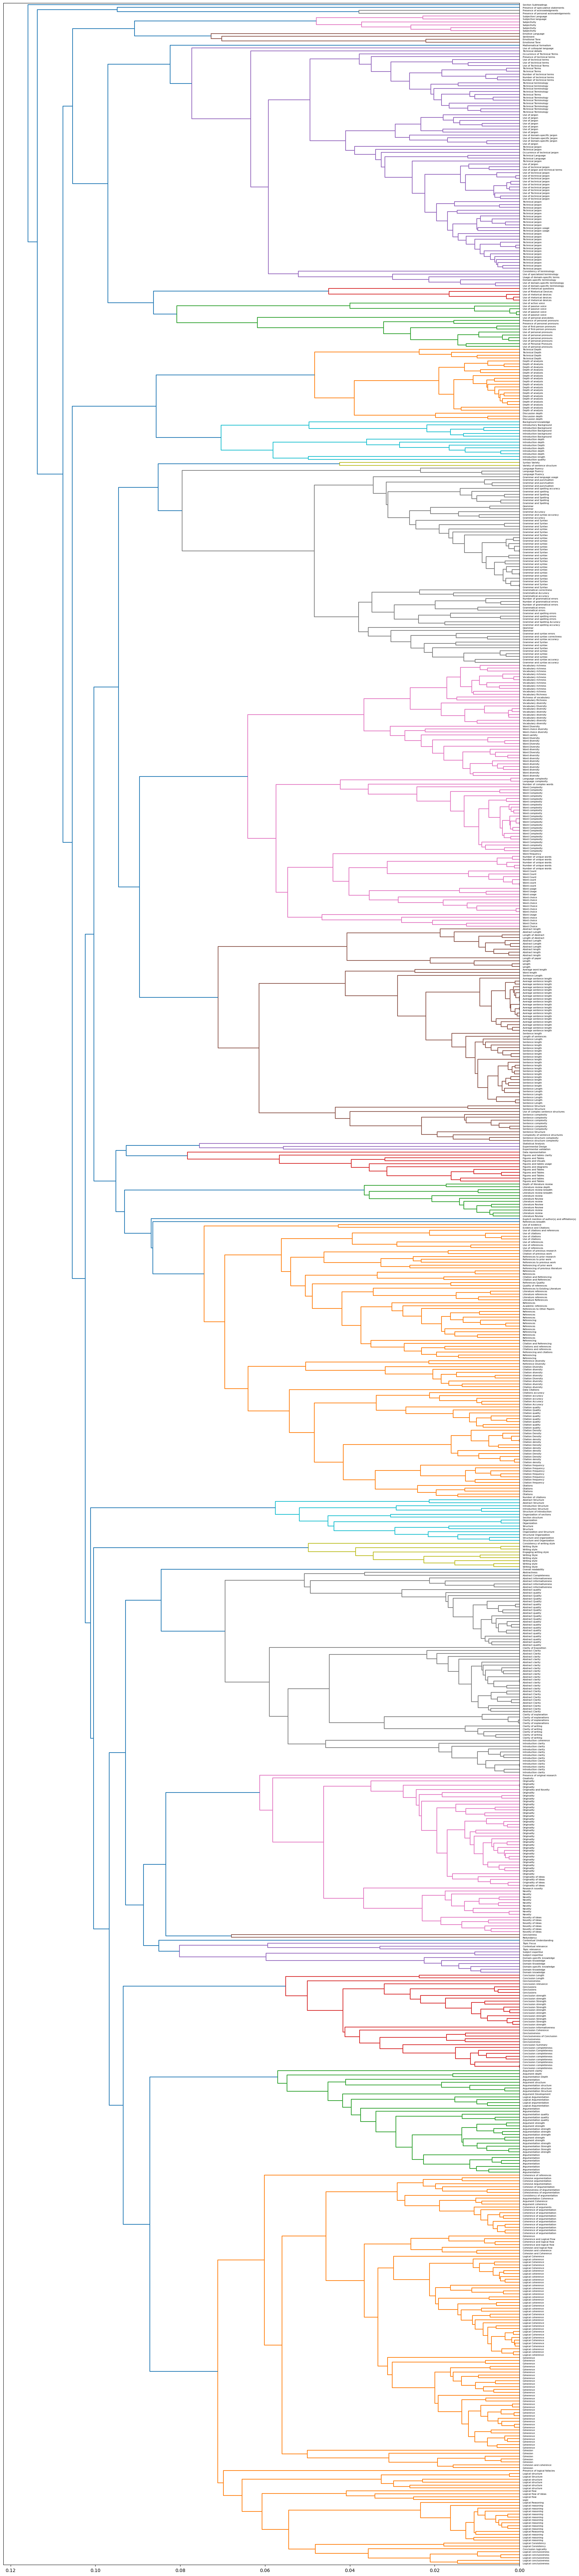

In [ ]:
# Perform hierarchical clustering on feature embeddings to identify similar features
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linked = linkage(feature_embeddings, method="average", metric="cosine")

# Determine dendrogram labels (feature names)
labels = [f.name for f in feature_set.features]

# Plot the dendrogram
plt.figure(figsize=(20, 100))
dendrogram(linked, orientation="left", labels=labels, distance_sort="descending", show_leaf_counts=True)
plt.show()

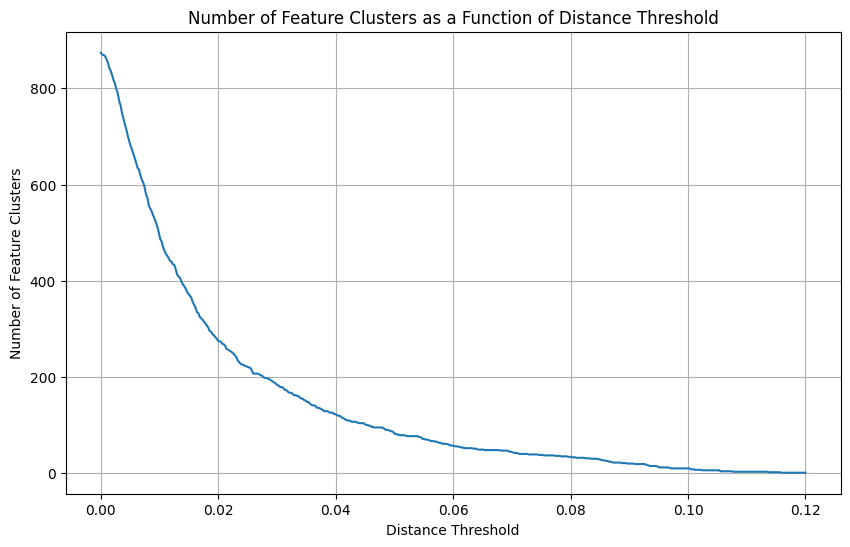

In [ ]:
# Plot the number of clusters as a function of the distance threshold
from scipy.cluster.hierarchy import fcluster

distance_thresholds = np.linspace(0.0, 0.12, 500)
num_clusters = [len(set(fcluster(linked, t, criterion="distance"))) for t in distance_thresholds]

plt.figure(figsize=(10, 6))
plt.plot(distance_thresholds, num_clusters)
plt.xlabel("Distance Threshold")
plt.ylabel("Number of Feature Clusters")
plt.title("Number of Feature Clusters as a Function of Distance Threshold")
plt.grid(True)
plt.show()

In [ ]:
# Choose a final distance threshold
distance_threshold = 0.05

# Form flat clusters
cluster_labels = fcluster(linked, distance_threshold, criterion="distance")

len(np.unique(cluster_labels))

83

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

# Find the unique cluster labels
unique_labels = np.unique(cluster_labels)

# Initialize a list to hold the representative points
representative_features = []

# Loop over each unique label
for label in unique_labels:
    # Get the points in this cluster
    cluster_points = np.array([(point, cluster_label, feature) for point, cluster_label, feature in zip(feature_embeddings, cluster_labels, feature_set.features) if cluster_label == label], dtype=object)

    # Calculate the centroid of these points
    centroid = np.mean([p[0] for p in cluster_points], axis=0)

    # Calculate the distance of each point from the centroid
    distances = cdist([centroid], [p[0] for p in cluster_points])[0]

    # Get the index of the closest point
    closest_point_idx = np.argmin(distances)

    # Get the closest point and add it to our list
    representative_features.append(cluster_points[closest_point_idx][2])

# Consolidate all representative features into a new feature set
feature_set_consolidated = FeatureSet(features=representative_features)
len(feature_set_consolidated.features)

83

In [ ]:
# Print the resulting features
pd.DataFrame(data=json.loads(feature_set_consolidated.json())["features"])

,name,zero,ten,hypothesis
0,Presence of acknowledgments,no acknowledgments section,detailed acknowledgments section,Human-written papers are likely to include mor...
1,Presence of speculative statements,No speculative statements,Frequent speculative statements,Machine-written papers would include more spec...
2,Subjectivity,Completely objective,Highly subjective,Machine-written papers are more likely to have...
3,Emotional Tone,neutral,emotional,Human-written papers are expected to have a mo...
4,Sentiment,negative sentiment,positive sentiment,Human-written papers may exhibit a more positi...
...,...,...,...,...
78,Logical flow,No logical flow,Strong logical flow,Human-written papers are likely to have a stro...
79,Logical reasoning,lack of logical reasoning,strong logical reasoning,Human-written papers are likely to exhibit str...
80,Logical conclusiveness,inconclusive,highly conclusive,Human-written papers are expected to have more...
81,Presence of logical fallacies,no logical fallacies,many logical fallacies,Machine-written papers are more likely to have...


In [ ]:
# Serializing json
json_object = feature_set_consolidated.json(indent=4)

# Store the results
filename = "2023_07_18 - Features Consolidated 0-100.json"
with open(filename, "w") as f:
    f.write(json_object)

# Download the results
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Upload the results
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Parse the results
flat_list = json.loads(uploaded[filename])["features"]
feature_set_consolidated = FeatureSet(features=flat_list)
len(feature_set_consolidated.features)

Saving 2023_07_18 - Features Consolidated 0-100.json to 2023_07_18 - Features Consolidated 0-100.json


83

# Score papers along the consolidated features

In [ ]:
# Initialize a list to log experiment results
results_log = []
error_log = []

In [ ]:
# Set up functionality to store experimental results for later evaluation
def log_result(data, index, result, messages, output, model_name, temperature, total_tokens, prompt_tokens, completion_tokens, cost, duration):
    dataset_features = data.features.keys()

    log = {
        "index": index,
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "config": {
            "model": model_name,
            "temperature": temperature
        },
        "paper": {
            "id": data["id"][index] if "id" in dataset_features else "",
            "year": data["year"][index] if "year" in dataset_features else "",
            "title": data["title"][index] if "title" in dataset_features else "",
            "abstract": data["abstract"][index] if "abstract" in dataset_features else "",
            "introduction": data["introduction"][index] if "introduction" in dataset_features else "",
            "conclusion": data["conclusion"][index] if "conclusion" in dataset_features else "",
            "categories": data["categories"][index] if "categories" in dataset_features else "",
            "src": data["src"][index] if "src" in dataset_features else "",
            "label": data["label"][index] if "label" in dataset_features else ""
        },
        "messages": messages,
        "output": output,
        "result": result,
        "consumption": {
            "tokens_used": total_tokens,
            "prompt_tokens": prompt_tokens,
            "completion_tokens": completion_tokens,
            "cost": cost
        },
        "duration": duration
    }

    results_log.append(log)
    return log


# Set up functionality to log errors
def log_error(index, error):
    error_log.append({"index": index, "error": error})

In [ ]:
n_sample = 200
start = 0
temperature = 0.0
train = True

data_real = train_real if train else test_real
data_fake = train_fake if train else test_fake

print(f"Starting scoring of {2*(n_sample-start)} papers from {'TRAIN' if train else 'TEST'} dataset ...")

# Set up the model
model = ChatOpenAI(model="gpt-3.5-turbo-16k-0613", temperature=temperature, openai_api_key=openai_key, openai_organization=openai_org)

for i in range(start, n_sample):
    try:
        # Score a real paper
        start_time = time.time()
        result, messages, output, consumption = score_paper(model, abstr=data_real["abstract"][i], intro=data_real["introduction"][i], concl=data_real["conclusion"][i], feature_set=feature_set_consolidated)
        duration = time.time() - start_time

        log_result(data=data_real, index=i, result=result, messages=messages, output=output, model_name=model.model_name, temperature=model.temperature, total_tokens=consumption.total_tokens, prompt_tokens=consumption.prompt_tokens, completion_tokens=consumption.completion_tokens, cost=consumption.total_cost, duration=duration)
        print(f"Example {i+1} of {n_sample}: Scored {len(feature_set_consolidated.features)} features of a {data_real['src'][i]} paper, {'{:.2f}'.format(duration)} seconds, {consumption.prompt_tokens} tokens in, {consumption.completion_tokens} tokens out, USD {'{:.5f}'.format(consumption.total_cost)}")
    except Exception as e:
        log_error(i, e)
        print(f"Example {i+1} of {n_sample}: Error {e}")

    try:
        # Score a fake paper
        start_time = time.time()
        result, messages, output, consumption = score_paper(model, abstr=data_fake["abstract"][i], intro=data_fake["introduction"][i], concl=data_fake["conclusion"][i], feature_set=feature_set_consolidated)
        duration = time.time() - start_time

        log_result(data=data_fake, index=i, result=result, messages=messages, output=output, model_name=model.model_name, temperature=model.temperature, total_tokens=consumption.total_tokens, prompt_tokens=consumption.prompt_tokens, completion_tokens=consumption.completion_tokens, cost=consumption.total_cost, duration=duration)
        print(f"Example {i+1} of {n_sample}: Scored {len(feature_set_consolidated.features)} features of a {data_fake['src'][i]} paper, {'{:.2f}'.format(duration)} seconds, {consumption.prompt_tokens} tokens in, {consumption.completion_tokens} tokens out, USD {'{:.5f}'.format(consumption.total_cost)}")
    except Exception as e:
        log_error(i, e)
        print(f"Example {i+1} of {n_sample}: Error {e}")

In [ ]:
# Store the results
filename = "2023_07_19 - Feature Learning TRAIN 600-TEST-400 0-1000.pickle"
pickle_out = open(filename, "wb")
pickle.dump(results_log, pickle_out)
pickle_out.close()

# Download the results
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train and evaluate Random Forest Classifier on consolidated features

In [ ]:
df_scores = pd.DataFrame([r["result"] for r in results_log])
df_scores["src"] = [r["paper"]["src"] for r in results_log]
df_scores["label"] = df_scores.apply(lambda x: "real" if x["src"] == "real" else "fake", axis=1)
df_scores

,presence_of_acknowledgments,presence_of_speculative_statements,subjectivity,emotional_tone,sentiment,emotive_language,technical_jargon,use_of_domain-specific_terminology,consistency_of_terminology,technical_details,...,cohesion,coherence_of_references,logical_structure,logical_flow,logical_reasoning,logical_conclusiveness,presence_of_logical_fallacies,section_subheadings,src,label
0,5,2,1,1,5,1,8,9,7,7,...,7,7,7,7,7,6,3,7,real,real
1,5,7,3,2,5,2,8,7,6,9,...,7,7,7,7,7,6,4,6,scigen,fake
2,8,2,1,1,1,1,7,8,7,9,...,7,8,7,7,7,7,2,7,real,real
3,5,0,0,0,0,0,10,10,10,10,...,8,8,8,8,8,8,0,8,galactica,fake
4,8,2,1,1,5,2,9,9,8,9,...,8,9,9,9,9,8,2,8,real,real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5,2,1,1,5,1,8,9,7,9,...,7,8,8,8,8,7,3,7,gpt2,fake
996,8,2,1,1,5,1,10,10,8,10,...,9,9,9,9,9,8,2,8,real,real
997,8,2,3,1,5,2,9,8,7,9,...,8,9,9,9,9,9,2,8,gpt3,fake
998,8,2,1,1,5,1,9,9,8,9,...,8,8,8,8,8,8,2,8,real,real


In [ ]:
filename = "2023_07_19 - Feature Learning TRAIN 600-TEST-400 0-1000.csv"

# Store the results
df_scores.to_csv(filename)

# Download the results
files.download(filename)

In [ ]:
# Upload the results
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Parse the results
df_scores = pd.read_csv(filename, index_col=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split DataFrame into input variables and label
X = df_scores.drop(columns=["src", "label"])
y = df_scores["label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=600, test_size=400, shuffle=False)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Train the model
rf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = rf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy and feature importances
print(f"Accuracy: {accuracy}")

Accuracy: 0.7975


In [ ]:
feature_names = df_scores.drop(columns=["src", "label"]).columns
feature_importances = rf.feature_importances_
pd.DataFrame(data={"Feature": feature_names, "Importance": feature_importances}).sort_values(by="Importance", ascending=False).head(10)

,Feature,Importance
22,grammar_and_syntax,0.047832
11,mathematical_formalism,0.035574
7,use_of_domain-specific_terminology,0.025750
52,abstract_clarity,0.023115
66,conclusion_length,0.021651
13,use_of_passive_voice,0.021326
5,emotive_language,0.018418
72,cohesion,0.018305
31,statistical_analysis,0.018026
79,section_subheadings,0.017967


# Train Random Forest on scored papers from TRAIN dataset

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split DataFrame into input variables and label
X = df_scores.drop(columns=["src", "label"])
y = df_scores["label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=600, test_size=400, shuffle=False)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Train the model
rf.fit(X_train, y_train)

# Predict the labels of the train set
y_pred = rf.predict(X_train)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_train, y_pred)

# Print the accuracy and feature importances
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
feature_names = df_scores.drop(columns=["src", "label"]).columns
feature_importances = rf.feature_importances_
pd.DataFrame(data={"Feature": feature_names, "Importance": feature_importances}).sort_values(by="Importance", ascending=False).head(10)

,Feature,Importance
22,grammar_and_syntax,0.047832
11,mathematical_formalism,0.035574
7,use_of_domain-specific_terminology,0.025750
52,abstract_clarity,0.023115
66,conclusion_length,0.021651
13,use_of_passive_voice,0.021326
5,emotive_language,0.018418
72,cohesion,0.018305
31,statistical_analysis,0.018026
79,section_subheadings,0.017967


# Evaluate accuracy on test datasets

In [ ]:
# Initialize a list to log experiment results
results_log = []
error_log = []

In [ ]:
n_sample = 100
start = 0
temperature = 0.0
data = tecg_shuffled

print(f"Starting scoring of {(n_sample-start)} papers ...")

# Set up the model
model = ChatOpenAI(model="gpt-3.5-turbo-16k-0613", temperature=temperature, openai_api_key=openai_key)#, openai_organization=openai_org)

for i in range(start, n_sample):
    try:
        # Score a paper
        start_time = time.time()
        result, messages, output, consumption = score_paper(model, abstr=data["abstract"][i], intro=data["introduction"][i], concl=data["conclusion"][i], feature_set=feature_set_consolidated)
        duration = time.time() - start_time

        log_result(data=data, index=i, result=result, messages=messages, output=output, model_name=model.model_name, temperature=model.temperature, total_tokens=consumption.total_tokens, prompt_tokens=consumption.prompt_tokens, completion_tokens=consumption.completion_tokens, cost=consumption.total_cost, duration=duration)
        print(f"Example {i+1} of {n_sample}: Scored {len(feature_set_consolidated.features)} features of a {data['src'][i]} paper, {'{:.2f}'.format(duration)} seconds, {consumption.prompt_tokens} tokens in, {consumption.completion_tokens} tokens out, USD {'{:.5f}'.format(consumption.total_cost)}")
    except Exception as e:
        log_error(i, e)
        print(f"Example {i+1} of {n_sample}: Error {e}")

In [ ]:
# Store the results
filename = "2023_07_28 - Feature Learning TECG 0-100.pickle"
pickle_out = open(filename, "wb")
pickle.dump(results_log, pickle_out)
pickle_out.close()

# Download the results
files.download(filename)

In [ ]:
df_scores_test = pd.DataFrame([r["result"] for r in results_log])
df_scores_test["src"] = [r["paper"]["src"] for r in results_log]
df_scores_test["label"] = df_scores_test.apply(lambda x: "real" if x["src"] == "real" or x["src"] == "ood_real" else "fake", axis=1)
df_scores_test

,presence_of_acknowledgments,presence_of_speculative_statements,subjectivity,emotional_tone,sentiment,emotive_language,technical_jargon,use_of_domain-specific_terminology,consistency_of_terminology,technical_details,...,cohesion,coherence_of_references,logical_structure,logical_flow,logical_reasoning,logical_conclusiveness,presence_of_logical_fallacies,section_subheadings,src,label
0,5,2,2,1,5,2,7,8,9,8,...,8,9,8,8,8,7,2,8,chatgpt,fake
1,5,0,0,0,0,0,8,8,9,7,...,7,8,8,8,8,7,0,7,chatgpt,fake
2,5,2,1,1,5,1,8,9,8,7,...,7,8,8,8,8,7,3,7,chatgpt,fake
3,5,2,1,1,5,1,8,9,8,7,...,7,8,7,7,8,7,2,6,chatgpt,fake
4,8,2,2,1,5,1,9,9,8,9,...,8,8,8,8,8,8,2,8,chatgpt,fake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,2,2,1,5,1,8,9,8,9,...,8,8,9,9,9,8,2,8,chatgpt,fake
96,8,2,3,1,5,2,9,8,7,9,...,8,9,9,9,8,7,2,8,chatgpt,fake
97,5,0,0,0,0,0,8,8,9,9,...,8,8,8,8,8,8,0,7,chatgpt,fake
98,5,2,1,1,5,1,8,9,8,7,...,8,8,8,8,8,7,2,7,chatgpt,fake


In [ ]:
filename = "2023_07_28 - Feature Learning TECG 0-100.csv"

# Store the results
df_scores.to_csv(filename)

# Download the results
files.download(filename)

In [ ]:
# Split DataFrame into input variables and label
X_test = df_scores_test.drop(columns=["src", "label"])
y_test = df_scores_test["label"]

# Predict the labels of the test set
y_pred = rf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy and feature importances
print(f"Accuracy: {accuracy}")

Accuracy: 0.9


# Evaluate results

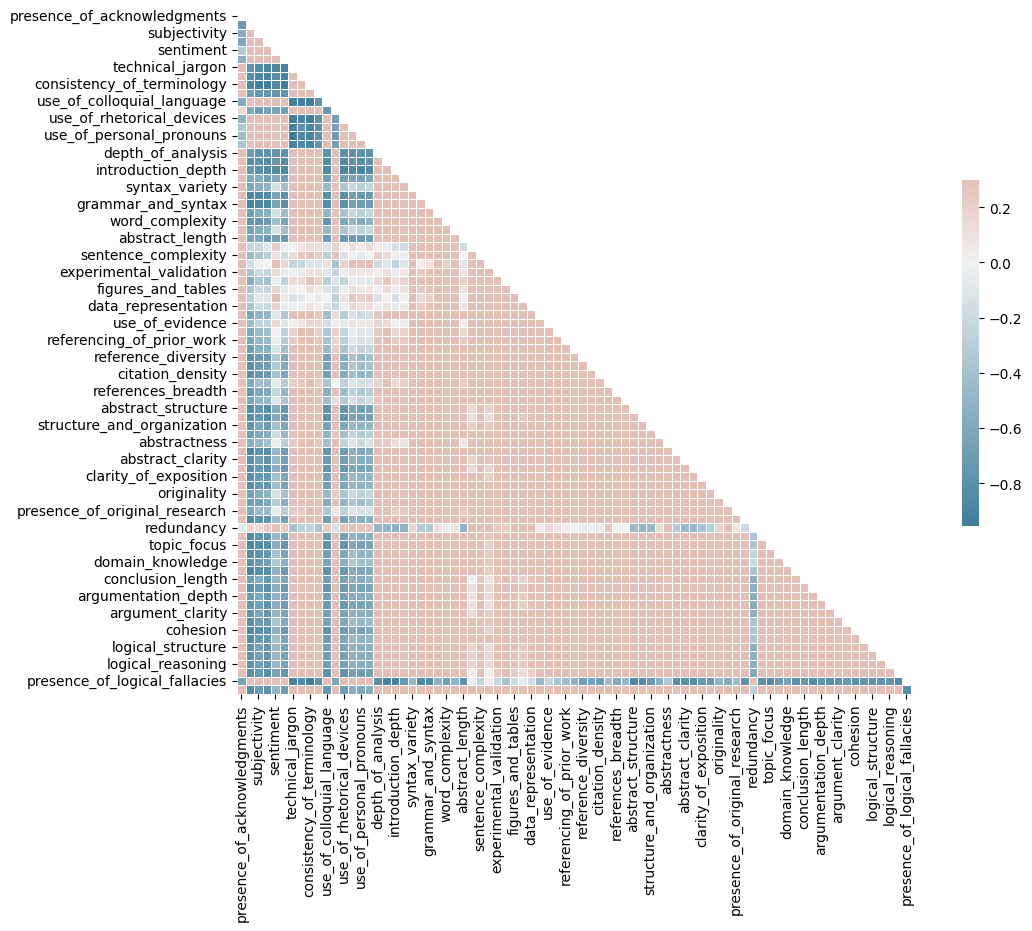

In [ ]:
# Plot feature correlations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
corr = df_scores.drop(columns=["src", "label"]).astype(int).corr().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

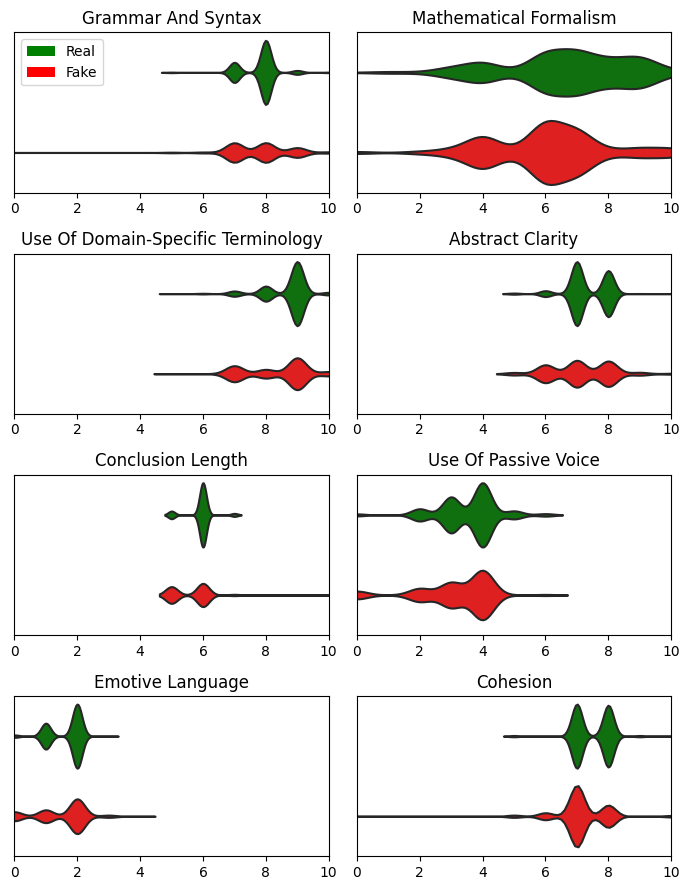

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming `df` is your DataFrame
df = df_scores.drop(columns=["src"])

# Convert all columns (except 'label') to integer
for col in df.columns:
    if col != 'label':
        df[col] = df[col].astype(int)

# Columns to be plotted
top_k = 8
cols_to_plot = list(pd.DataFrame(data={"Feature": df_scores.drop(columns=["src", "label"]).columns, "Importance": rf.feature_importances_}).sort_values(by="Importance", ascending=False).head(top_k)["Feature"])
# cols_to_plot = [col for col in df.columns if col != 'label' and col in top_features]

# Number of columns for the grid
grid_cols = 2

# Create a figure and axes with a grid of subplots
fig, axes = plt.subplots((len(cols_to_plot) + grid_cols - 1) // grid_cols, grid_cols, figsize=(7, 9))

# Flatten the array of axes, so that we can easily iterate over it
axes = axes.flatten()

# Create legend manually
legend_elements = [Patch(facecolor='green', label='Real'), Patch(facecolor='red', label='Fake')]

# Iterate over all columns of the DataFrame, and for each column, create a violin plot
for i, col in enumerate(cols_to_plot):
    violin = sns.violinplot(x=col, y='label', data=df, palette={'real': 'g', 'fake': 'r'}, split=True, inner=None, ax=axes[i])
    axes[i].set_xlim(0, 10)  # Setting the x axis scale to range from 0 to 10
    axes[i].set_title(col.replace("_", " ").title())  # Setting the title to the feature name
    axes[i].set_ylabel('')  # Removing the y axis label
    axes[i].set_xlabel('')  # Removing the x axis label
    axes[i].set_yticks([])  # Removing the tickmarks on the y axis

    # Add legend only to the first plot
    if i == 0:
        axes[i].legend(handles=legend_elements, loc='upper left')

# Remove remaining axes that did not get a subplot
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# Store and download the plot
filename = "llmfe-distributions.pdf"
plt.savefig(filename, format="pdf", bbox_inches="tight")
files.download(filename)

plt.show()